In [1]:
import os
import tensorflow as tf
print(tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

In [2]:



#TRAIN_SIZE = int(TOTSAMPLE*0.8)
#TRAIN_SIZE = 5462
TRAIN_SIZE = 8000
#EVAL_SIZE = 395 #Use when non-ag included (does not include slope)
#EVAL_SIZE = TOTSAMPLE - TRAIN_SIZE
#EVAL_SIZE = 523
EVAL_SIZE = 2000

# Specify model training parameters.
BATCH_SIZE = 32
EPOCHS = 1000 #Should auto-stop
BUFFER_SIZE = TRAIN_SIZE+BATCH_SIZE


YEARS_PYTHON = ['2005', '2016']
FOLIUMLOCATION = [39.811,-111.625,]

ALL_BANDS = [f'BGR{i}_median' for i in range(3)]+[f'SWIR{i}_median' for i in range(3)]+[f'SR_TH_median']+\
                [f'BGR{i}_diff' for i in range(3)]+[f'SWIR{i}_diff' for i in range(3)]+[f'SR_TH_diff']+\
                [f'BGR{i}_stdDev' for i in range(3)]+[f'SWIR{i}_stdDev' for i in range(3)]+[f'SR_TH_stdDev']


import re
BANDS_TO_USE = ALL_BANDS
        
#RESPONSE = ['Drip', 'Dry Crop', 'Flood', 'Sprinkler'] #Use if drip is to be trained for
#RESPONSE = ['Dry Crop', 'Flood', 'Sprinkler'] 
#RESPONSE = ['Flood', 'Sprinkler'] 
#RESPONSE =['Irrigation']
RESPONSE = ['flood', 'sprinkler', 'other']
#RESPONSE_TO_USE = ['sprinkler']
RESPONSE_TO_USE = RESPONSE

ALL_FEATURES = ALL_BANDS+RESPONSE
FEATURES_TO_USE = BANDS_TO_USE+RESPONSE_TO_USE

if len(RESPONSE_TO_USE) >1:
    OPTIMIZER = 'Adam'
    LOSS = 'categorical_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'softmax'
else:
    OPTIMIZER = 'Adam'
    LOSS = 'binary_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'sigmoid'


# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 64
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in ALL_FEATURES
]
COLUMNS2 = [
  tf.io.FixedLenFeature([], tf.string) for k in ALL_FEATURES
]
ALL_FEATURES_DICT = dict(zip(ALL_FEATURES, COLUMNS))
ALL_FEATURES_DICT_STRING = dict(zip(ALL_FEATURES, COLUMNS2))



# Specify names locations for outputs in Cloud Storage. 
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL'
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_NoNormalization'
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_22_22'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_22_22'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l5_9_26_22'
FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_lib7_4_l8l5_avg_2'
TRAINING_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_train'
EVAL_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_eval'






# Training data

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [3]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  example_message = tf.io.parse_single_example(example_proto, ALL_FEATURES_DICT_STRING)
  features = {}
  for feature_name in example_message:
    thisfeature = example_message[feature_name]
    features[feature_name] = tf.io.parse_tensor(thisfeature, out_type=tf.float32)
        
  return features

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES_TO_USE]
  #inputsList = normalize_inputs(inputs)
  
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS_TO_USE)], stacked[:,:,len(BANDS_TO_USE):]

def sample_to_dict(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = {key:inputs.get(key) for key in FEATURES_TO_USE}
    return inputsList



In [4]:
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)


In [5]:

def do_not_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]    
    


def get_dataset(fname_):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    dataset = tf.data.TFRecordDataset(fname_)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(sample_to_dict)
    return dataset


# Use the helpers to read in the training dataset.  Print the first record to check.

# In[36]:

def get_year_data_T(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

def get_year_data_E(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

    

In [6]:
SAMPLES_PER_YEAR = 200    
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)

NYEARS = len(YEARS)


import json
Nsamples = {}
with open(os.path.join(FOLDER, 'NSamples.json'), 'r') as fh:
    Nsamples = json.load(fh)

print(f'Samples per year: {Nsamples}')
sampl_tot = {'Training':0,'Evaluation':0}
for spl in Nsamples['Training']:
    sampl_tot['Training'] += Nsamples['Training'][spl]
    sampl_tot['Evaluation'] += Nsamples['Evaluation'][spl]
NWEIGHTS = {'Training':{}, 'Evaluation':{}}
for spl in Nsamples['Training']:
    NWEIGHTS['Training'][int(spl)] = min(SAMPLES_PER_YEAR/Nsamples['Training'][spl], 1.0)
    NWEIGHTS['Evaluation'][int(spl)] = min((SAMPLES_PER_YEAR/4)/Nsamples['Evaluation'][spl], 1.0)


Samples per year: {'Training': {'2003': 882, '2004': 565, '2005': 321, '2006': 582, '2007': 383, '2008': 243, '2009': 657, '2010': 506, '2011': 345, '2013': 196, '2014': 210, '2015': 659, '2018': 754, '2019': 763, '2020': 729, '2021': 738}, 'Evaluation': {'2003': 231, '2004': 140, '2005': 67, '2006': 142, '2007': 98, '2008': 55, '2009': 179, '2010': 124, '2011': 85, '2013': 48, '2014': 48, '2015': 177, '2018': 191, '2019': 186, '2020': 189, '2021': 189}}


Use the helpers to read in the training dataset.  Print the first record to check.

In [7]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{TRAINING_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Training'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

training = get_training_dataset()

#print(iter(training.take(1)).next())

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

In [21]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{EVAL_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Evaluation'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS/4)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

evaluation = get_eval_dataset()

In [22]:
import numpy as np
##Show a few evaluation images
import skimage.color # functions for manipulating color images
import skimage.transform # functions for transforms on images
import numpy as np
import matplotlib.pyplot as plt # visualization
import random
bands_dict = dict(zip(BANDS_TO_USE, enumerate(BANDS_TO_USE)))
print(bands_dict)

def show_input_img():
    plt.figure(figsize=(20,20))
    subplot_rows = 3 # determine subplots rows
    cnt = 0
    rand_ind = random.randrange(sampl_tot['Evaluation'])
    for eval_batch in evaluation:
        for isple, sample_eval in enumerate(eval_batch[0]):
            if cnt == rand_ind:
                break
            cnt += 1
        if cnt == rand_ind:
            break
            
            #print(sample_eval)
    img = sample_eval
    imginput = np.expand_dims(img.numpy(), 0)
    band_cnt = 0
    for band_ in BANDS_TO_USE:
        ax = plt.subplot(subplot_rows*3,7,7*(band_cnt//7)+1+band_cnt%7) # choose current subplot
        image = img.numpy()[:,:,[bands_dict[band_][0],
                                 bands_dict[band_][0],
                                 bands_dict[band_][0]]]
        plt.imshow(np.squeeze(image)) # plot activations ,cmap='gray'
        plt.axis('off')
        band_cnt += 1

{'BGR0_median': (0, 'BGR0_median'), 'BGR1_median': (1, 'BGR1_median'), 'BGR2_median': (2, 'BGR2_median'), 'SWIR0_median': (3, 'SWIR0_median'), 'SWIR1_median': (4, 'SWIR1_median'), 'SWIR2_median': (5, 'SWIR2_median'), 'SR_TH_median': (6, 'SR_TH_median'), 'BGR0_diff': (7, 'BGR0_diff'), 'BGR1_diff': (8, 'BGR1_diff'), 'BGR2_diff': (9, 'BGR2_diff'), 'SWIR0_diff': (10, 'SWIR0_diff'), 'SWIR1_diff': (11, 'SWIR1_diff'), 'SWIR2_diff': (12, 'SWIR2_diff'), 'SR_TH_diff': (13, 'SR_TH_diff'), 'BGR0_stdDev': (14, 'BGR0_stdDev'), 'BGR1_stdDev': (15, 'BGR1_stdDev'), 'BGR2_stdDev': (16, 'BGR2_stdDev'), 'SWIR0_stdDev': (17, 'SWIR0_stdDev'), 'SWIR1_stdDev': (18, 'SWIR1_stdDev'), 'SWIR2_stdDev': (19, 'SWIR2_stdDev'), 'SR_TH_stdDev': (20, 'SR_TH_stdDev')}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

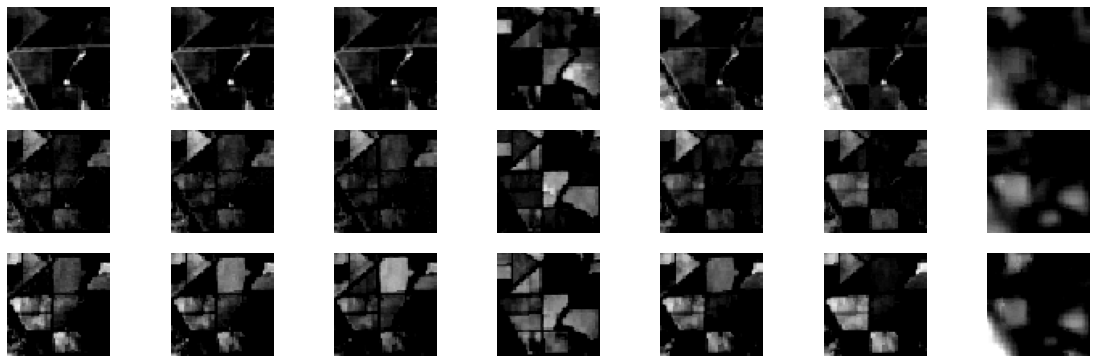

In [26]:
show_input_img()